# Chemical space

This notebook visualizes the chemical space of co-crystallized ligands in the benchmark dataset. The notebook was inspired by a [blog post](http://practicalcheminformatics.blogspot.com/2019/11/visualizing-chemical-space.html) from Patrick Walters.

In [1]:
import math
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
docking_benchmark_dataset = pd.read_csv("../data/docking_benchmark_dataset.csv", index_col=0)

Variance explained by 50 PCA components: 0.6369755215015859



/home/david/miniconda3/envs/kinoml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/david/miniconda3/envs/kinoml/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


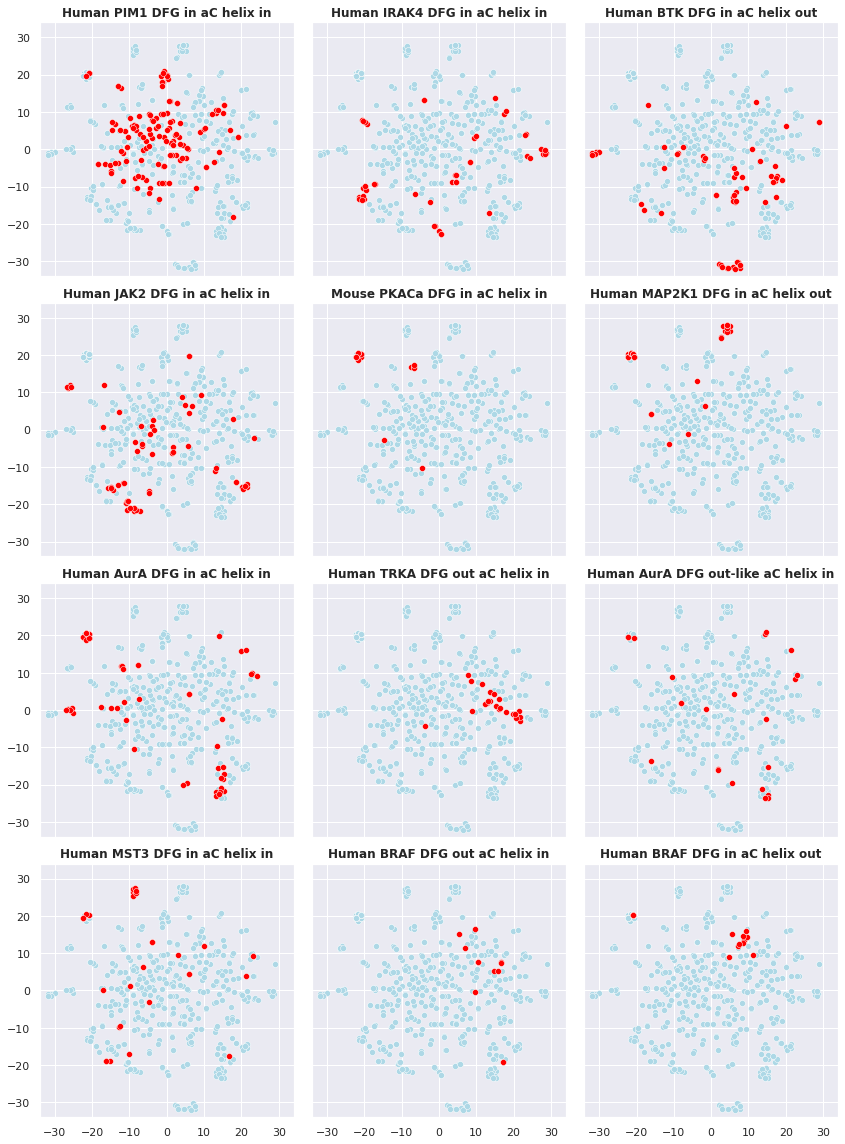

In [5]:
def plot_chemical_space(docking_benchmark_dataset, n_components=50, directory=OUT_DIR):
    
    # get unique ligands
    ligands = docking_benchmark_dataset.groupby(["ligand.expo_id", "smiles"]).head(1)[["ligand.expo_id", "smiles"]]
    
    # add fingerprints
    rdkit_mols = [Chem.MolFromSmiles(smiles) for smiles in ligands["smiles"]]
    fingerprints = [
        np.asarray(GetMorganFingerprintAsBitVect(rdkit_mol, radius=2, nBits=2048, useFeatures=True), dtype="int64")
        for rdkit_mol in rdkit_mols
    ]
    ligands["fingerprint"] = fingerprints
    
    # perform PCA
    pca = PCA(n_components=n_components)
    coordinates = pca.fit_transform(list(ligands["fingerprint"])) 
    print(f"Variance explained by {n_components} PCA components: {np.sum(pca.explained_variance_ratio_)}\n")
    
    # perform TSNE
    embedded_coordinates = TSNE(n_components=2).fit_transform(coordinates)
    max_absolute_coordinate = math.ceil(abs(embedded_coordinates).max() + 1)
    
    # merge TSNE coordinates to benchmark dataset
    ligands["X"] = [x[0] for x in embedded_coordinates]
    ligands["Y"] = [x[1] for x in embedded_coordinates]
    ligands.drop("smiles", axis=1, inplace=True)
    docking_benchmark_dataset = pd.merge(docking_benchmark_dataset, ligands, how='left', on="ligand.expo_id")
    
    # get benchmark groups
    benchmark_groups = docking_benchmark_dataset.groupby(["kinase.klifs_id", "structure.dfg", "structure.ac_helix"]).head(1)
    
    # 12 subplots
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(12, 16))
    
    for i, (_, benchmark_group) in enumerate(benchmark_groups.iterrows()):
        
        # get row and column
        row = i // 3
        column = 0
        if i in [1, 4, 7, 10]:
            column = 1
        if i in [2, 5, 8, 11]:
            column = 2
                        
        # get group data
        subset = docking_benchmark_dataset[
            (docking_benchmark_dataset["kinase.klifs_id"] == benchmark_group["kinase.klifs_id"]) &
            (docking_benchmark_dataset["structure.dfg"] == benchmark_group["structure.dfg"]) &
            (docking_benchmark_dataset["structure.ac_helix"] == benchmark_group["structure.ac_helix"])
        ]
        
        # plot TSNE
        sns.scatterplot(data=docking_benchmark_dataset, x="X", y="Y", color='lightblue', ax=axes[row][column])
        sns.scatterplot(data=subset, x="X", y="Y", color='red', ax=axes[row][column])
        
        # plot formatting
        axes[row][column].set_xlabel("")
        axes[row][column].set_ylabel("")
        axes[row][column].set_xlim([max_absolute_coordinate * -1, max_absolute_coordinate])
        axes[row][column].set_ylim([max_absolute_coordinate * -1, max_absolute_coordinate])
        axes[row][column].set_aspect("equal")
        axes[row][column].set_title(
            f"{subset.iloc[0]['species.klifs']} {subset.iloc[0]['kinase.klifs_name']} "
            f"DFG {subset.iloc[0]['structure.dfg']} aC helix {subset.iloc[0]['structure.ac_helix']}", 
            fontweight="bold"
        )
        
    plt.tight_layout()
    plt.savefig(directory / "chemical_space.pdf", dpi=300)
        
    return


plot_chemical_space(docking_benchmark_dataset)